In [1]:
import pandas as pd
import numpy as np
import math
import os

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("price_data.csv")

# Set first column name
df.columns.values[0] = "Stock"

# Make that column indexes (row)
df = df.set_index('Stock')

# Make columns datetime
df.columns = pd.to_datetime(df.columns)

# Make all numeric
df = df.apply(pd.to_numeric, errors="coerce")

# drop row if all NaN
df.dropna(how='all', inplace=True)

# drop column if all NaN
df.dropna(how='all', axis=1, inplace=True)

In [4]:
df.head()

,1990-01-31 00:00:00,1990-02-28 00:00:00,1990-03-30 00:00:00,1990-04-30 00:00:00,1990-05-31 00:00:00,1990-06-29 00:00:00,1990-07-31 00:00:00,1990-08-31 00:00:00,1990-09-28 00:00:00,1990-10-31 00:00:00,...,2017-09-29 00:00:00,2017-10-31 00:00:00,2017-11-30 00:00:00,2017-12-29 00:00:00,2018-01-31 00:00:00,2018-02-28 00:00:00,2018-03-30 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-29 00:00:00
Stock,,,,,,,,,,,,,,,,,,,,,
2S TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.27,3.98,4.39,4.44,4.30,4.20,4.00,3.78,3.5,3.06
A TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,6.55,6.55,6.60,6.65,6.70,6.70,6.70,6.7,6.70
AAV TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.55,6.40,6.20,6.15,5.70,5.55,5.15,5.85,5.5,5.00
ABICO TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.75,9.75,9.20,9.45,8.85,7.85,7.95,7.85,6.3,5.95
ABPIF TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.45,8.60,8.55,8.55,8.90,8.70,8.50,8.55,8.5,8.50


In [5]:
print("Left with {} stocks, and {} date columns".format(df.shape[0], df.shape[1]))

Left with 743 stocks, and 342 date columns


In [6]:
cols_before_march_1998 = df.columns[df.columns.values < np.datetime64('1998-03-01')]

In [7]:
df = df.drop(cols_before_march_1998, axis=1)

In [8]:
df.head()

,1998-03-31 00:00:00,1998-04-30 00:00:00,1998-05-29 00:00:00,1998-06-30 00:00:00,1998-07-31 00:00:00,1998-08-31 00:00:00,1998-09-30 00:00:00,1998-10-30 00:00:00,1998-11-30 00:00:00,1998-12-31 00:00:00,...,2017-09-29 00:00:00,2017-10-31 00:00:00,2017-11-30 00:00:00,2017-12-29 00:00:00,2018-01-31 00:00:00,2018-02-28 00:00:00,2018-03-30 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-29 00:00:00
Stock,,,,,,,,,,,,,,,,,,,,,
2S TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.27,3.98,4.39,4.44,4.30,4.20,4.00,3.78,3.5,3.06
A TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,6.55,6.55,6.60,6.65,6.70,6.70,6.70,6.7,6.70
AAV TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.55,6.40,6.20,6.15,5.70,5.55,5.15,5.85,5.5,5.00
ABICO TB Equity,1.19,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,...,9.75,9.75,9.20,9.45,8.85,7.85,7.95,7.85,6.3,5.95
ABPIF TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.45,8.60,8.55,8.55,8.90,8.70,8.50,8.55,8.5,8.50


In [9]:
@interact(index=(0,len(df.index)-1))
def view_stocks(index=0):
    i = index
    df.iloc[i].plot(kind='line', title=df.index[i])

interactive(children=(IntSlider(value=0, description='index', max=742), Output()), _dom_classes=('widget-inter…

## Strategy Calculation (Holding-Observing)

o, h is period of time in months (o = observing/h = hoding)

In [10]:
# calculate sum of winner/loser 2deciles on holding period
def mean_decile_winners_losers_hold(RO, RH, irange, debug_list=False):
    i = irange
    ro, rh = RO[:, i], RH[:, i]

    # Concat o, h
    oh = np.vstack([ro, rh]).T
    
    # remove rows that have nan
    oh = oh[~np.isnan(oh).any(axis=1)]

    # sort by winners in observing period
    sorted_inds_desc = oh[:,0].argsort()[::-1]
    oh = oh[sorted_inds_desc]

    # get decile range
    decile_num = math.ceil(oh.shape[0]/10)

    winners = oh[:decile_num]
    losers = oh[-decile_num:]
    
    if debug_list:        
        return (winners, losers)

    mean_winners_hold = winners[:,1].mean()
    mean_losers_hold = losers[:,1].mean()
    return (mean_winners_hold, mean_losers_hold)
    

# o, h is number of months
def strategy(o, h, M):
    nrows, ncols = M.shape
    
    oh_total_range = o+1+h
    num_possible_ranges = ncols - oh_total_range + 1
    
    if num_possible_ranges <= 0:
        raise ValueError('num_possible_ranges must > 0.')
    
    RO = np.zeros([nrows, num_possible_ranges])
    RH = np.zeros([nrows, num_possible_ranges])

    # for each stock
    for r in range(nrows):
        
        # for each o/h range til the end
        for ic in range(num_possible_ranges):
            
            m = M[r, ic:ic+oh_total_range] # get that range
            if np.isnan(m).any(): # one value is nan -> ignore stock at this range
                RO[r, ic] = np.nan
                RH[r, ic] = np.nan
                continue
                
            p0 = m[0] # start
            p1 = m[o] # start - observe
            p2 = m[o + h] # observe - hold
            
            # Handle divided by 0
            if p0 == 0:
                returnO = 0
            else:
                returnO = p1/p0 - 1
                
                
            if p1 == 0:
                returnH = 0
            else:
                returnH = p2/p1 - 1                
                
            RO[r, ic]= returnO
            RH[r, ic] = returnH
    
    S_W = np.zeros(num_possible_ranges)
    S_L = np.zeros(num_possible_ranges)

    # calculate sum of winner/loser on holding period
    for i in range(num_possible_ranges):
        sw, sl = mean_decile_winners_losers_hold(RO, RH, i)
        S_W[i] = sw
        S_L[i] = sl
        
    return np.vstack([S_W, S_L]).T
    

## Add Date, Year, and Month columns for easier selection

In [11]:
dft = df.T
dft['Date'] = dft.index
dft['Year'] = dft['Date'].apply(lambda dt: dt.year)
dft['Month'] = dft['Date'].apply(lambda dt: dt.month)
dft.head()

Stock,2S TB Equity,A TB Equity,AAV TB Equity,ABICO TB Equity,ABPIF TB Equity,ACAP TB Equity,ACC TB Equity,ADB TB Equity,ADVANC TB Equity,AEC TB Equity,...,WINNER TB Equity,WORK TB Equity,WPH TB Equity,XO TB Equity,YUASA TB Equity,ZIGA TB Equity,ZMICO TB Equity,Date,Year,Month
1998-03-31,NaN,NaN,NaN,1.19,NaN,NaN,5.95,NaN,30.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.39,1998-03-31,1998,3
1998-04-30,NaN,NaN,NaN,0.70,NaN,NaN,5.57,NaN,26.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.43,1998-04-30,1998,4
1998-05-29,NaN,NaN,NaN,0.70,NaN,NaN,5.11,NaN,22.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.95,1998-05-29,1998,5
1998-06-30,NaN,NaN,NaN,0.70,NaN,NaN,4.73,NaN,16.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.83,1998-06-30,1998,6
1998-07-31,NaN,NaN,NaN,0.70,NaN,NaN,4.81,NaN,21.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.95,1998-07-31,1998,7


## Year 2017, First three months, to check 1x1

In [12]:
d2017 = dft[(dft.Year == 2017) & (dft.Month <= 3)]
d2017_no_date = d2017.drop(columns=['Date', 'Year', 'Month']).T # drop date columns before calculation
s_winner, s_loser = strategy(1,1,d2017_no_date.values)[0]
print("1x1, Year 2017, month 1-3")
print("Mean winner = {}\nMean loser = {}".format(s_winner, s_loser))

1x1, Year 2017, month 1-3
Mean winner = 0.03196124979924586
Mean loser = 0.012534448909006297


In [13]:
debug = dft[['PE TB Equity', 'RCL TB Equity']][(dft.Year == 2017) & (dft.Month <= 3)].T
debug

,2017-01-31 00:00:00,2017-02-28 00:00:00,2017-03-31 00:00:00
Stock,,,
PE TB Equity,0.88,0.78,0.79
RCL TB Equity,6.95,6.15,7.15


In [14]:
WL = None
observing_periods = [1,3,6,12]
holding_periods = [1,3,6,12,36,60]
reload = False

if os.path.exists('./WL.npy') and not reload:
    print('Detected WL.npy, loading...')
    WL = np.load('WL.npy')
    print('WL.npy is loaded from disk.')
else:
    if reload:
        print('forced reloading WL.npy...')
    else:
        print('No WL.npy detected, calculating new one...')
    D = df.values
    R, C = D.shape
    # R is total num of stocks
    WL = np.zeros([len(observing_periods),len(holding_periods), R, 2])
    WL[:] = np.nan
    for io, o in enumerate(observing_periods):
        for ih, h in enumerate(holding_periods):
            res  = strategy(o, h, D)
            WL[io, ih, :res.shape[0], :] =  res
    print('Saving WL.npy...')
    np.save('WL.npy', WL)
    print('WL.npy is saved to disk.')

Detected WL.npy, loading...
WL.npy is loaded from disk.


In [15]:
def explore(o, h):
    oi = observing_periods.index(o)
    hi = holding_periods.index(h)
    res = WL[oi, hi]
    wins = res[:,0]
    losers = res[:,1]
    w, = plt.plot(wins, label='Sum of winners')
    l, = plt.plot(losers, label='Sum of losers')
    plt.legend(handles=[w,l])

o_slider = widgets.SelectionSlider(
    options=observing_periods,
    value=1,
    description='Observing period (months)',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True)

h_slider = widgets.SelectionSlider(
    options=holding_periods,
    value=1,
    description='Holding period (months)',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True)


w = interactive(explore, o=o_slider, h=h_slider)

In [16]:
display(w)

interactive(children=(SelectionSlider(description='Observing period (months)', options=(1, 3, 6, 12), value=1)…

Text(0.5,0.92,'Diff winner and losers for each strategy')

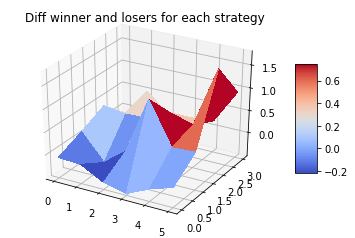

In [17]:
# WL[np.isnan(WL)] = 0
WL_nan_is_zero = np.copy(WL)
WL_nan_is_zero[np.isnan(WL)] = 0
WL_ = WL_nan_is_zero
WLdiff = WL_[:,:,0] - WL_[:,:,1]
WLdiff = WLdiff.mean(axis=2)

x = np.arange(len(holding_periods))
y = np.arange(len(observing_periods))
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, WLdiff, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Diff winner and losers for each strategy')

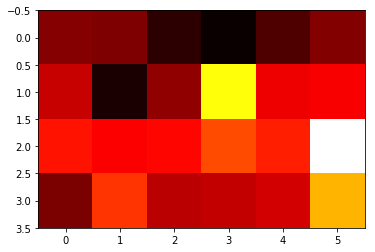

In [18]:
plt.imshow(WLdiff, cmap='hot', interpolation='nearest')

## Save to Excel

In [19]:
from StyleFrame import StyleFrame

writer = pd.ExcelWriter('output.xlsx')

summary_table = pd.DataFrame(np.zeros((len(observing_periods), len(holding_periods))), columns=holding_periods, index=observing_periods)

for io, o in enumerate(observing_periods):
    for ih, h in enumerate(holding_periods):
        data = WL[io, ih, :, :]
        data = data[~np.isnan(data).any(axis=1)]
        diff = data[:, 0] - data[:, 1]
        avg = diff.mean()
        summary_table.iloc[io, ih] = avg

summary_table.to_excel(writer, "summary")
        

for io, o in enumerate(observing_periods):
    for ih, h in enumerate(holding_periods):
        data = WL[io, ih, :, :]
        data = data[~np.isnan(data).any(axis=1)]
        result_df = pd.DataFrame(data=data, columns=['Average winner', 'Average loser'])
        
        # remove NA
        result_df.dropna(how='all', axis=1, inplace=True)
        
        # Add Diff
        result_df['Diff'] = result_df['Average winner'] - result_df['Average loser']
        
        avg = result_df['Diff'].mean()
        std =result_df['Diff'].std()

        result_df['Average of Diffs'] = np.nan
        result_df['Average of Diffs'][0] = avg
        
        result_df['STD of Diffs'] = np.nan
        result_df['STD of Diffs'][0] = std
        
        summary_table.iloc[io, ih] = avg
        
        final = result_df
        
        final = StyleFrame(final)
        final.set_column_width(columns=final.columns, width=20)
        final.set_row_height(rows=final.row_indexes, height=20)        
        final.to_excel(writer,"{}x{}".format(o,h))
        
writer.save()

In [20]:
def load_dataframe_from_disk(name, calculate, force_reload=False):
    if os.path.exists('./{0}'.format(name)) and not force_reload:
        print('Detected {0}, loading...'.format(name))
        data = pd.read_pickle(name)
        print('{0} is loaded from disk.'.format(name))
        return data
    else:
        if force_reload:
            print('forced reloading {0}...'.format(name))
        else:
            print('No {0} detected, calculating new one...'.format(name))
        data = calculate()
        print('Saving {0}...'.format(name))
        data.to_pickle(name)
        print('{0} is saved to disk.'.format(name))
        return data
    

## Load PB Data and inverse

In [21]:
def get_pb_inv_data():
    df_pb_data = pd.read_csv("pb_data.csv")

    # Set first column name
    df_pb_data.columns.values[0] = "Stock"

    # Make that column indexes (row)
    df_pb_data = df_pb_data.set_index('Stock')

    # Make columns datetime
    df_pb_data.columns = pd.to_datetime(df_pb_data.columns)

    # Make all numeric
    df_pb_data = df_pb_data.apply(pd.to_numeric, errors="coerce")

    cols_before_march_1998 = df_pb_data.columns[df_pb_data.columns.values < np.datetime64('1998-03-01')]

    df_pb_data = df_pb_data.drop(cols_before_march_1998, axis=1)

    # drop row if all NaN
    df_pb_data.dropna(how='all', inplace=True)

    # drop column if all NaN
    df_pb_data.dropna(how='all', axis=1, inplace=True)
    
    # inverse
    return df_pb_data.applymap(lambda x: 1/x)

## Classfiy Stock Values

In [22]:
def get_df_value_labels():
    df_pb_inv_data = get_pb_inv_data()
    total_months = df_pb_inv_data.shape[1]
    df_value_labels = pd.DataFrame(columns=df_pb_inv_data.columns, index=df_pb_inv_data.index)

    for mi in range(total_months):
        by_name = df_pb_inv_data.columns[mi]
        sorted_series = df_pb_inv_data.iloc[:, mi].sort_values(axis=0)
        sorted_series_no_na = sorted_series.dropna()
        stocks_count = sorted_series_no_na.values.shape[0]
        growth_until_ind = np.ceil(stocks_count * 0.3).astype(int)
        value_from_ind = np.ceil(stocks_count * 0.7).astype(int)

        df_value_labels.loc[sorted_series_no_na.iloc[:growth_until_ind].index, df_pb_inv_data.columns[mi]] = 0
        df_value_labels.loc[sorted_series_no_na.iloc[growth_until_ind:value_from_ind].index, df_pb_inv_data.columns[mi]] = 1
        df_value_labels.loc[sorted_series_no_na.iloc[value_from_ind:].index, df_pb_inv_data.columns[mi]] = 2
        
    return df_value_labels

In [23]:
df_value_labels = load_dataframe_from_disk('df_value_labels.pkl', get_df_value_labels, force_reload=False)
df_value_labels.head()        

Detected df_value_labels.pkl, loading...
df_value_labels.pkl is loaded from disk.


,1998-03-31 00:00:00,1998-04-30 00:00:00,1998-05-29 00:00:00,1998-06-30 00:00:00,1998-07-31 00:00:00,1998-08-31 00:00:00,1998-09-30 00:00:00,1998-10-30 00:00:00,1998-11-30 00:00:00,1998-12-31 00:00:00,...,2017-09-29 00:00:00,2017-10-31 00:00:00,2017-11-30 00:00:00,2017-12-29 00:00:00,2018-01-31 00:00:00,2018-02-28 00:00:00,2018-03-30 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-29 00:00:00
Stock,,,,,,,,,,,,,,,,,,,,,
2S TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
A TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
AAV TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
ABICO TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,1,0,1,1
ABPIF TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,2,2,2,1


## Load mkt cap data

In [24]:
def get_mktcap_data():
    df = pd.read_csv("mktcap_data.csv")

    # Set first column name
    df.columns.values[0] = "Stock"

    # Make that column indexes (row)
    df = df.set_index('Stock')

    # Make columns datetime
    df.columns = pd.to_datetime(df.columns)

    # Make all numeric
    df = df.apply(pd.to_numeric, errors="coerce")

    cols_before_march_1998 = df.columns[df.columns.values < np.datetime64('1998-03-01')]

    df = df.drop(cols_before_march_1998, axis=1)

    # drop row if all NaN
    df.dropna(how='all', inplace=True)

    # drop column if all NaN
    df.dropna(how='all', axis=1, inplace=True)
    
    return df

In [25]:
def get_df_size_labels():
    df_mktcap_data = get_mktcap_data()
    total_months = df_mktcap_data.shape[1]
    df_size_labels = pd.DataFrame(columns=df_mktcap_data.columns, index=df_mktcap_data.index)

    for mi in range(total_months):
        by_name = df_mktcap_data.columns[mi]
        sorted_series = df_mktcap_data.iloc[:, mi].sort_values(axis=0)
        sorted_series_no_na = sorted_series.dropna(axis=0)
        stocks_count = sorted_series_no_na.values.shape[0]
        ind_median = np.ceil(stocks_count/2).astype(int)

        df_size_labels.loc[sorted_series_no_na.iloc[:ind_median].index, df_size_labels.columns[mi]] = 0
        df_size_labels.loc[sorted_series_no_na.iloc[ind_median:].index, df_size_labels.columns[mi]] = 1
    return df_size_labels

In [26]:
df_size_labels = load_dataframe_from_disk('df_size_labels.pkl', get_df_size_labels, force_reload=False)
df_size_labels

Detected df_size_labels.pkl, loading...
df_size_labels.pkl is loaded from disk.


,1998-03-31 00:00:00,1998-04-30 00:00:00,1998-05-29 00:00:00,1998-06-30 00:00:00,1998-07-31 00:00:00,1998-08-31 00:00:00,1998-09-30 00:00:00,1998-10-30 00:00:00,1998-11-30 00:00:00,1998-12-31 00:00:00,...,2017-10-31 00:00:00,2017-11-30 00:00:00,2017-12-29 00:00:00,2018-01-31 00:00:00,2018-02-28 00:00:00,2018-03-30 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-29 00:00:00,2018-07-31 00:00:00
Stock,,,,,,,,,,,,,,,,,,,,,
2S TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
A TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
AAV TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
ABICO TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
ABPIF TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
ACAP TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,0,0
ACC TB Equity,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ADB TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0,0,0
ADVANC TB Equity,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


### Match common indices and columns

In [28]:
common_indices = df.index.intersection(df_value_labels.index).intersection(df_size_labels.index)
common_columns = df.columns.intersection(df_value_labels.columns).intersection(df_size_labels.columns)
df = df.loc[common_indices, common_columns]
df_value_labels = df_value_labels.loc[common_indices, common_columns]
df_size_labels = df_size_labels.loc[common_indices, common_columns]
# (df.index == df_value_labels.index).all()

## Calculate Momentum Per-Label

In [29]:
print(df_value_labels.shape)
print(df_size_labels.shape)
print(df.shape)

(729, 244)
(729, 244)
(729, 244)


In [30]:
# calculate sum of winner/loser 2deciles on holding period
def mean_decile_winners_losers_hold(RO, RH, irange, debug_list=False):
    i = irange
    ro, rh = RO[:, i], RH[:, i]

    # Concat o, h
    oh = np.vstack([ro, rh]).T
    
    # remove rows that have nan
    oh = oh[~np.isnan(oh).any(axis=1)]

    # sort by winners in observing period
    sorted_inds_desc = oh[:,0].argsort()[::-1]
    oh = oh[sorted_inds_desc]

    # get decile range
    decile_num = math.ceil(oh.shape[0]/10)

    winners = oh[:decile_num]
    losers = oh[-decile_num:]
    
    if debug_list:        
        return (winners, losers)

    mean_winners_hold = winners[:,1].mean()
    mean_losers_hold = losers[:,1].mean()
    return (mean_winners_hold, mean_losers_hold)
    

# o, h is number of months, valueLabel = {0,1,2} sizeLabel = {0,1}
def strategy_for_label(o, h, df, value_label, size_label, df_value_labels, df_size_labels):
    if value_label not in [0,1,2]:
        raise ValueError('Invalid value_label {0}.'.format(value_label))
    if size_label not in [0,1]:
        raise ValueError('Invalid size_label {0}.'.format(size_label))
        
    M = df.values
    nrows, ncols = M.shape
    
    oh_total_range = o+1+h
    num_possible_ranges = ncols - oh_total_range + 1
    
    if num_possible_ranges <= 0:
        raise ValueError('num_possible_ranges must > 0.')
    
    RO = np.zeros([nrows, num_possible_ranges])
    RH = np.zeros([nrows, num_possible_ranges])
    
    RO[:] = np.nan
    RH[:] = np.nan

    # for each stock
    for r in range(nrows):
        
        # for each o/h range til the end
        for ic in range(num_possible_ranges):
            
            stock_value_label = df_value_labels.iloc[r, ic]
            stock_size_label = df_size_labels.iloc[r, ic]
            any_is_nan = np.isnan(stock_value_label) or np.isnan(stock_size_label)
            is_target_label = (stock_value_label == value_label) and (stock_size_label == size_label)
            
            if (not is_target_label):
#                 print('not target')
                continue
            
            if (any_is_nan):
#                 print('any is nan!')
                continue
            
            m = M[r, ic:ic+oh_total_range] # get that range
            if np.isnan(m).any(): # one value is nan -> ignore stock at this range
#                 print('some price is nan')
                continue
    
            if (m == 0).any():
                continue
                
#             print("calculate!!!",r , ic)
            p0 = m[0] # start
            p1 = m[o] # start - observe
            p2 = m[o + h] # observe - hold
            
            if p0 == 0 or p1 == 0:
                continue
            
            # Handle divided by 0
            returnO = p1/p0 - 1
            returnH = p2/p1 - 1
                
            RO[r, ic]= returnO
            RH[r, ic] = returnH
    
    S_W = np.zeros(num_possible_ranges)
    S_L = np.zeros(num_possible_ranges)

    # calculate sum of winner/loser on holding period
    for i in range(num_possible_ranges):
        sw, sl = mean_decile_winners_losers_hold(RO, RH, i)
        S_W[i] = sw
        S_L[i] = sl
        
    return np.vstack([S_W, S_L]).T

### Optimized strategy label

In [101]:
# o, h is number of months, valueLabel = {0,1,2} sizeLabel = {0,1}
def optimized_strategy_for_label(o, h, df, value_label, size_label, df_value_labels, df_size_labels):
    if value_label not in [0,1,2]:
        raise ValueError('Invalid value_label {0}.'.format(value_label))
    if size_label not in [0,1]:
        raise ValueError('Invalid size_label {0}.'.format(size_label))
        
    M = df.values
    nrows, ncols = M.shape
    
    oh_total_range = o+1+h
    num_possible_ranges = ncols - oh_total_range + 1
    
    if num_possible_ranges <= 0:
        raise ValueError('num_possible_ranges must > 0.')

    S_WL = np.zeros((num_possible_ranges,2))
    S_WL[:] = np.nan
    
    for ic in range(num_possible_ranges):
        target_label_filter = (df_value_labels == value_label)  & (df_size_labels == size_label)
        m = M[target_label_filter.values[:,ic],ic:ic+oh_total_range]
        m = m[~np.isnan(m).any(axis=1)] # if any in row is nan -> remove
        m = m[~(m == 0).any(axis=1)] # if any in row = 0 -> remove

        p0 = m[:,0] # start
        p1 = m[:,o] # start - observe
        p2 = m[:,o + h] # observe - hold
            
        # Handle divided by 0
        returnO = p1/p0 - 1
        returnH = p2/p1 - 1
        oh = np.vstack([returnO,returnH]).T
        oh = oh[~np.isnan(oh).any(axis=1)]
        sorted_inds_desc = oh[:,0].argsort()[::-1] # win to lose
        oh = oh[sorted_inds_desc]
        decile_num = math.ceil(oh.shape[0]/10)
        winners = oh[:decile_num]
        losers = oh[-decile_num:]
        mean_winners_hold = winners[:,1].mean()
        mean_losers_hold = losers[:,1].mean()
        S_WL[ic,:] = [mean_winners_hold, mean_losers_hold]
        
    return S_WL

In [102]:
data = optimized_strategy_for_label(1, 1, df, 0, 0, df_value_labels, df_size_labels)

[[ 8.25  8.38  7.63]
 [ 0.98  0.98  0.98]
 [ 0.69  0.75  0.56]]
[[ 0.08695652 -0.25333333]
 [ 0.01575758 -0.08949881]
 [ 0.          0.        ]]


In [97]:
data

array([[  1.57575758e-02,  -1.75000000e-01],
       [ -2.53333333e-01,   0.00000000e+00],
       [  0.00000000e+00,   5.45454545e-02],
       [ -3.44827586e-01,   2.15982721e-01],
       [  0.00000000e+00,   3.68421053e-01],
       [ -1.53846154e-01,  -3.92592593e-01],
       [  2.93255132e-02,   9.59183673e-01],
       [ -5.20833333e-02,   6.39344262e-01],
       [  3.16414687e-01,   5.66037736e-02],
       [ -3.33333333e-01,   0.00000000e+00],
       [ -1.87500000e-01,   1.11111111e-01],
       [  3.00000000e-01,   3.42857143e-01],
       [  2.78911565e-01,   2.50000000e-01],
       [  1.06250000e+00,   7.95918367e-01],
       [ -6.13026820e-02,   0.00000000e+00],
       [  5.00000000e-02,   6.81818182e-02],
       [ -2.65957447e-01,   1.61290323e-01],
       [  5.55555556e-02,   1.26436782e-01],
       [ -7.69230769e-02,  -1.25000000e-01],
       [  1.11111111e-02,   4.92063492e-01],
       [  0.00000000e+00,   0.00000000e+00],
       [ -2.01976638e-01,  -2.66806723e-01],
       [  

In [59]:
df.columns[:4]

DatetimeIndex(['1998-03-31', '1998-04-30', '1998-05-29', '1998-06-30'], dtype='datetime64[ns]', freq='BM')

## Number of stocks of each group

In [85]:
# stock_values = [2]
stock_values = [0,1,2]
values_name = { 0: 'growth', 1: 'neutral', 2: 'value' }
# stock_sizes = [1]
stock_sizes = [0,1]
sizes_name = { 0: 'small', 1: 'big'}

In [86]:
for v in stock_values:
    for s in stock_sizes:
        count = ((df_value_labels == v) & (df_size_labels == s)).values.sum()
        print('#{}-{} = {}'.format(v,s,count))

#0-0 = 8718
#0-1 = 22386
#1-0 = 19138
#1-1 = 22137
#2-0 = 21737
#2-1 = 8984


In [87]:
df.columns.astype(str)

Index(['1998-03-31', '1998-04-30', '1998-05-29', '1998-06-30', '1998-07-31',
       '1998-08-31', '1998-09-30', '1998-10-30', '1998-11-30', '1998-12-31',
       ...
       '2017-09-29', '2017-10-31', '2017-11-30', '2017-12-29', '2018-01-31',
       '2018-02-28', '2018-03-30', '2018-04-30', '2018-05-31', '2018-06-29'],
      dtype='object', length=244)

In [89]:
month_labels = df.columns.values.astype(str)

In [93]:
from StyleFrame import StyleFrame
from tqdm import tqdm_notebook as tqdm

num_stocks, num_months = df.shape

WL_labels = np.zeros([len(stock_values), len(stock_sizes), len(observing_periods), len(holding_periods), num_months, 2])
WL_labels[:] = np.nan

month_labels = df.columns.astype(str)

for ival, val in enumerate(tqdm(stock_values, desc='Value')):
    for isize, size in enumerate(tqdm(stock_sizes, desc='Size')):
#         if val==2 and size==1:
#             print('skip val2 size1')
#             continue
        
        writer = pd.ExcelWriter('labels/{}-{}.xlsx'.format(values_name[val], sizes_name[size]))
        
        summary_table = pd.DataFrame(np.zeros((len(observing_periods), len(holding_periods))), columns=holding_periods, index=observing_periods)
        
        for io, o in enumerate(tqdm(observing_periods, desc='Observe')):
            for ih, h in enumerate(tqdm(holding_periods, desc='Hold')):
                
#                 if o != 1 or h != 1:
#                     continue
                data = optimized_strategy_for_label(o, h, df, val, size, df_value_labels, df_size_labels)
                
                if data.size == 0:
                    print('Found size 0 at {} {} {} {}'.format(val, size, o, h))
                    continue                    
                    
                result_df = pd.DataFrame(data=data, 
                                         columns=['Average winner', 'Average loser'])
                
                result_df['Datetime'] = month_labels[:data.shape[0]]
                
                # remove NA
                result_df.dropna(how='all', axis=1, inplace=True)

                # Add Diff
                result_df['Diff'] = result_df['Average winner'] - result_df['Average loser']

                avg = result_df['Diff'].mean()
                std =result_df['Diff'].std()
                n = result_df.shape[0]
                std_error = avg/(std/np.sqrt(n))

                result_df['Average of Diffs'] = np.nan
                result_df['Average of Diffs'][0] = avg

                result_df['STD of Diffs'] = np.nan
                result_df['STD of Diffs'][0] = std
                
                result_df['N'] = np.nan
                result_df['N'][0] = n
                
                result_df['STD Error'] = np.nan
                result_df['STD Error'][0] = std_error

                final = result_df

                final = StyleFrame(final)
                final.set_column_width(columns=final.columns, width=20)
                final.set_row_height(rows=final.row_indexes, height=20)        
                final.to_excel(writer,"{}x{}".format(o,h))
                
                summary_table.iloc[io,ih] = avg
                
        summary_table.to_excel(writer,"avg summary")
        writer.save()
        print('Done labels/{}-{}.xlsx'.format(values_name[val], sizes_name[size]))
                

/Users/AunN/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/AunN/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/AunN/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:55: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/AunN/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:58: SettingWithCopyWarning:
A

Done labels/growth-small.xlsx


Done labels/growth-big.xlsx


Done labels/neutral-small.xlsx


Done labels/neutral-big.xlsx


Done labels/value-small.xlsx


Done labels/value-big.xlsx


In [2]:
def save_stock_labels_excel():
    wr = pd.ExcelWriter('stock_labels.xlsx')        
    d = df_size_labels.copy()
    d.columns = d.columns.astype(str)
    d.to_excel(wr,"sizes")

    d = df_value_labels.copy()
    d.columns = d.columns.astype(str)
    d.to_excel(wr,"values")

    wr.save()